I will be living in the Chicago area soon as part of my Master's program at the University of Chicago. As someone who enjoyed using the electric bikes and scooters located on my undergrad campus, UCLA, I wanted to analyze some behaviors and patterns from the Chicago bike-sharing system that also services the UChicago campus area, Divvy.

This is a follow-up to my quick case study in to Divvy Bikes, in which I analyzed some of the behaviors and differences in behavior that non-member riders and member riders exhibited.

In this follow-up I will build a classifier that, given some ride data, will predict if the rider was a non-member or a member.

Divvy provides its past ride data [here](https://divvy-tripdata.s3.amazonaws.com/index.html). Learn more about Divvy's data collection and terms [here](https://divvybikes.com/system-data) I am using the ride data from the past year, so from May 2022 to May 2023.

**Disclaimer**: I do not own any of data in this study. All rights are with Divvy and Motivate.


#### Imports
First we need to import everything we need.

In [2]:
# essential
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for building models
import xgboost
from xgboost import XGBClassifier

import lightgbm
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

from tqdm import tqdm

## Loading and Processing the data
(**Note**: This is a different data cleaning/transformation process than my exploratory study)

Now we want to load the datasets. I am using the Divvy Bikes data from 05/2022 to 05/2023, where *month_k.csv* represents the *k*-th month in 05/2022 to 05/2023. Thus, *month_1.csv* represents 05/2022, etc and *month_13.csv* represents the data from 05/2023. I am loading all of these datasets into a list of DataFrames and combining in to a single DataFrame.

In [9]:
df_list = []
for i in range(1,14):
    df_list.append(pd.read_csv('month_' + str(i) + '.csv'))

df = pd.concat(df_list, ignore_index=True)

I am going to add several columns to the data:
- *ride_length* which is just the duration of the ride, in minutes
- *day_of_week* which is the day of week of the ride
- *month* which is the month of the ride
- *time_of_day* which corresponds to morning, day, evening, night, based on the breakdown of the starting time of the ride.
    - morning (0): 4 A.M - 10 A.M
    - day (1): 10 A.M - 4 P.M
    - evening (2): 4 P.M - 10 P.M
    - night (3): 10 P.M - 4 A.M

In [10]:
df[['started_at','ended_at']] = df[['started_at','ended_at']].apply(pd.to_datetime)
df['ride_length'] = (df['ended_at'] - df['started_at'])/np.timedelta64(1, 'm')
df['day_of_week'] = df['started_at'].dt.dayofweek
df['month'] = df['started_at'].dt.month


In [11]:
daytime_breakdown = [(df['started_at'].dt.hour >= 4) & (df['started_at'].dt.hour < 10),
                     (df['started_at'].dt.hour >= 10) & (df['started_at'].dt.hour < 16),
                     (df['started_at'].dt.hour >= 16) & (df['started_at'].dt.hour < 22),
                     (df['started_at'].dt.hour >= 22) | (df['started_at'].dt.hour < 4)]
values = [0, 1, 2, 3]

df['time_of_day'] = np.select(daytime_breakdown, values)
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week,month,time_of_day
0,EC2DE40644C6B0F4,classic_bike,2022-05-23 23:06:58,2022-05-23 23:40:19,Wabash Ave & Grand Ave,TA1307000117,Halsted St & Roscoe St,TA1309000025,41.891466,-87.626761,41.943670,-87.648950,member,33.350000,0,5,3
1,1C31AD03897EE385,classic_bike,2022-05-11 08:53:28,2022-05-11 09:31:22,DuSable Lake Shore Dr & Monroe St,13300,Field Blvd & South Water St,15534,41.880958,-87.616743,41.886349,-87.617517,member,37.900000,2,5,0
2,1542FBEC830415CF,classic_bike,2022-05-26 18:36:28,2022-05-26 18:58:18,Clinton St & Madison St,TA1305000032,Wood St & Milwaukee Ave,13221,41.882242,-87.641066,41.907655,-87.672552,member,21.833333,3,5,2
3,6FF59852924528F8,classic_bike,2022-05-10 07:30:07,2022-05-10 07:38:49,Clinton St & Madison St,TA1305000032,Clark St & Randolph St,TA1305000030,41.882242,-87.641066,41.884576,-87.631890,member,8.700000,1,5,0
4,483C52CAAE12E3AC,classic_bike,2022-05-10 17:31:56,2022-05-10 17:36:57,Clinton St & Madison St,TA1305000032,Morgan St & Lake St,TA1306000015,41.882242,-87.641066,41.885779,-87.651025,member,5.016667,1,5,2


In [12]:
df.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    921249
start_station_id      921381
end_station_name      984928
end_station_id        985069
start_lat                  0
start_lng                  0
end_lat                 6683
end_lng                 6683
member_casual              0
ride_length                0
day_of_week                0
month                      0
time_of_day                0
dtype: int64

We see that we have several rows with null values for the ending latitude/longitude. We can remove those rows, ultimately these rows are a very very small part of our dataset which is well over 6 million rows long.

In [13]:
df = df.dropna(axis=0, subset=['end_lat', 'end_lng'], thresh=2)
df.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    921249
start_station_id      921381
end_station_name      978245
end_station_id        978386
start_lat                  0
start_lng                  0
end_lat                    0
end_lng                    0
member_casual              0
ride_length                0
day_of_week                0
month                      0
time_of_day                0
dtype: int64

Now I will rescale the latitude/longitude measurements relative to the latitude and longitude of Chicago. Google Maps tells me that Chicago's coordinates are 41.876064649109196, -87.62966486386428.


In [14]:
chicago_lat = 41.876064649109196
chicago_lng = -87.62966486386428
df['start_lat'] = df['start_lat'] - chicago_lat
df['start_lng'] = df['start_lng'] - chicago_lng
df['end_lat'] = df['end_lat'] - chicago_lat
df['end_lng'] = df['end_lng'] - chicago_lng
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week,month,time_of_day
0,EC2DE40644C6B0F4,classic_bike,2022-05-23 23:06:58,2022-05-23 23:40:19,Wabash Ave & Grand Ave,TA1307000117,Halsted St & Roscoe St,TA1309000025,0.015401,0.002904,0.067605,-0.019285,member,33.350000,0,5,3
1,1C31AD03897EE385,classic_bike,2022-05-11 08:53:28,2022-05-11 09:31:22,DuSable Lake Shore Dr & Monroe St,13300,Field Blvd & South Water St,15534,0.004893,0.012922,0.010284,0.012148,member,37.900000,2,5,0
2,1542FBEC830415CF,classic_bike,2022-05-26 18:36:28,2022-05-26 18:58:18,Clinton St & Madison St,TA1305000032,Wood St & Milwaukee Ave,13221,0.006177,-0.011401,0.031590,-0.042887,member,21.833333,3,5,2
3,6FF59852924528F8,classic_bike,2022-05-10 07:30:07,2022-05-10 07:38:49,Clinton St & Madison St,TA1305000032,Clark St & Randolph St,TA1305000030,0.006177,-0.011401,0.008512,-0.002225,member,8.700000,1,5,0
4,483C52CAAE12E3AC,classic_bike,2022-05-10 17:31:56,2022-05-10 17:36:57,Clinton St & Madison St,TA1305000032,Morgan St & Lake St,TA1306000015,0.006177,-0.011401,0.009715,-0.021360,member,5.016667,1,5,2


We can also check to see if we have any duplicates.

In [15]:
df.duplicated().sum()

0

We can now remove several columns, namely the ride id, the start/end time, and the starting/ending station name and id.

In [16]:
df = df.drop(['ride_id','started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name','end_station_id'], axis=1)
df.head()

,rideable_type,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week,month,time_of_day
0,classic_bike,0.015401,0.002904,0.067605,-0.019285,member,33.350000,0,5,3
1,classic_bike,0.004893,0.012922,0.010284,0.012148,member,37.900000,2,5,0
2,classic_bike,0.006177,-0.011401,0.031590,-0.042887,member,21.833333,3,5,2
3,classic_bike,0.006177,-0.011401,0.008512,-0.002225,member,8.700000,1,5,0
4,classic_bike,0.006177,-0.011401,0.009715,-0.021360,member,5.016667,1,5,2


Now we can change the *rideable_type* column to 0, 1, 2 based on if it is a *classic_bike*, *docked_bike*, or *electric_bike*.
Similarly, we can change the *member_casual* column to 0, 1 based on if the rider is a *casual* or *member*.
Let's also change the positions of our dataframe for clarity.

In [17]:
df['rideable_type'] = df['rideable_type'].map({'classic_bike': 0, 'docked_bike': 1, 'electric_bike': 2})
df['member_casual'] = df['member_casual'].map({'casual': 0, 'member': 1})
df = df[['member_casual', 'rideable_type', 'ride_length', 'month', 'day_of_week', 'time_of_day', 'start_lat', 'start_lng', 'end_lat', 'end_lng']]
df.head()

,member_casual,rideable_type,ride_length,month,day_of_week,time_of_day,start_lat,start_lng,end_lat,end_lng
0,1,0,33.350000,5,0,3,0.015401,0.002904,0.067605,-0.019285
1,1,0,37.900000,5,2,0,0.004893,0.012922,0.010284,0.012148
2,1,0,21.833333,5,3,2,0.006177,-0.011401,0.031590,-0.042887
3,1,0,8.700000,5,1,0,0.006177,-0.011401,0.008512,-0.002225
4,1,0,5.016667,5,1,2,0.006177,-0.011401,0.009715,-0.021360


We can also check for any rides that are outliers with respect to their ride length, in which case we see a lot of outliers, particularly some extreme values like 30000 minutes, and even -10000 minutes.

There appears to be many ride entries who have invalid start and end times, or just plain errors. Such as having an end time before the start time, or outlandish times such as ride durations in the 10000s of minutes. These are obvious outliers that have arisen due to carelessness or perhaps technical faults. Additionally, there are large collections of rides with around 1500 minutes, which is outlandish.

In [18]:
df1 = df.sort_values(by=['ride_length'])
df1.head(10)

,member_casual,rideable_type,ride_length,month,day_of_week,time_of_day,start_lat,start_lng,end_lat,end_lng
3431277,1,2,-10353.350000,9,2,1,-0.095488,0.044494,-0.096065,0.039665
3869072,1,0,-168.700000,10,3,1,0.056353,-0.023040,0.056353,-0.023040
1220530,0,2,-137.416667,6,1,2,0.053935,-0.160335,0.053935,-0.160335
760967,0,2,-130.033333,6,1,2,0.023935,-0.110335,0.033935,-0.110335
936135,1,2,-129.083333,6,1,2,0.041766,-0.023698,0.043935,-0.020335
761390,0,2,-127.016667,6,1,2,0.043935,-0.020335,0.043935,-0.020335
1211309,0,2,-126.150000,6,1,2,0.043935,-0.090335,0.053935,-0.090335
1220526,0,2,-125.500000,6,1,2,0.053935,-0.000335,0.073935,-0.010335
1220150,1,2,-117.100000,6,1,2,0.053935,-0.130335,0.083935,-0.110335
1203648,0,2,-101.333333,6,1,2,0.043935,-0.090335,0.053935,-0.160335


In [19]:
df2 = df.sort_values(by=['ride_length'],ascending=False)
df2.head()

,member_casual,rideable_type,ride_length,month,day_of_week,time_of_day,start_lat,start_lng,end_lat,end_lng
2121523,0,1,32035.450000,7,0,2,0.004893,0.012922,0.007537,-0.018962
5871760,0,1,12136.300000,5,1,1,-0.003333,-0.003851,0.067285,-0.041003
1416020,0,1,10807.216667,7,6,2,0.004893,0.012922,0.042231,-0.022518
172215,0,1,10722.966667,5,0,1,-0.047273,-0.050939,0.042231,-0.022518
2121118,0,1,9962.350000,7,4,1,0.010911,0.016852,0.007537,-0.018962


In [20]:
df[(df['ride_length'] < 0)]

,member_casual,rideable_type,ride_length,month,day_of_week,time_of_day,start_lat,start_lng,end_lat,end_lng
592385,0,2,-0.200000,5,0,1,0.073004,-0.018834,0.073935,-0.020335
760967,0,2,-130.033333,6,1,2,0.023935,-0.110335,0.033935,-0.110335
761390,0,2,-127.016667,6,1,2,0.043935,-0.020335,0.043935,-0.020335
913663,1,2,-1.183333,6,3,2,0.003935,-0.020335,0.007537,-0.018962
936135,1,2,-129.083333,6,1,2,0.041766,-0.023698,0.043935,-0.020335
...,...,...,...,...,...,...,...,...,...,...
6070769,0,0,-0.050000,5,1,2,-0.022850,-0.002207,-0.022850,-0.002207
6075920,1,0,-0.100000,5,5,2,-0.022850,-0.002207,-0.022850,-0.002207
6195541,1,2,-0.133333,5,0,1,0.023935,0.009665,0.024896,0.005888
6276412,1,0,-0.233333,5,5,0,0.063413,-0.034083,0.063413,-0.034083


I will be removing the comically large negative ride, and the rides with over 720 minutes. Anything over 720 minutes corresponds to  over 12 hours of biking which I believe is a good cutoff for an invalid data entry.
Furthermore, Divvy's data policy specifies that they remove entries with trip times of less than one minute. If we assume the non-comically large negative ride durations are valid and due to a technical fault that swapped their start and end times, there are still some entries with less than one minute of ride time. Since I am going to try to adhere to Divvy's data policy, I will remove these values as well, which is a non-insignificant portion of our values. Afterwards, I will switch the negative ride lengths, which are all now within reason, to positive values.

In [21]:
df[(df['ride_length'] <= 1) & (df['ride_length'] >= -1)]

,member_casual,rideable_type,ride_length,month,day_of_week,time_of_day,start_lat,start_lng,end_lat,end_lng
25,1,0,0.750000,5,3,2,0.024615,-0.032935,0.024615,-0.032935
88,0,2,0.166667,5,6,3,0.073935,-0.060335,0.073935,-0.060335
164,1,0,0.233333,5,0,2,0.015401,0.002904,0.015401,0.002904
165,1,0,0.416667,5,1,2,0.067286,-0.041003,0.067286,-0.041003
166,1,0,0.416667,5,1,2,0.067286,-0.041003,0.067286,-0.041003
...,...,...,...,...,...,...,...,...,...,...
6463753,1,2,0.133333,5,6,1,0.020663,-0.001024,0.023935,-0.000335
6463802,1,2,0.900000,5,3,1,0.053935,-0.010335,0.053935,-0.010335
6463825,1,2,0.133333,5,5,2,-0.081848,0.028182,-0.086065,0.029665
6463860,1,2,0.033333,5,3,2,-0.041335,0.003769,-0.046065,-0.000335


In [22]:
df['ride_length'] = abs(df['ride_length'])
df = df.drop(df[df['ride_length'] <= 1].index, axis=0)
df = df.drop(df[df['ride_length'] >= 720].index, axis=0)
print(len(df))

6295102


In [23]:
df['member_casual'].value_counts(normalize=True)

member_casual
1    0.598849
0    0.401151
Name: proportion, dtype: float64

Some plots to demonstrate some early insights between members and non-members.

<Axes: xlabel='day_of_week', ylabel='Count'>

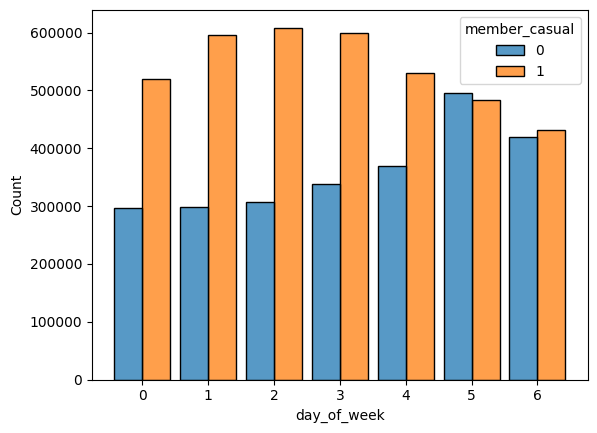

In [24]:
sns.histplot(data=df,x='day_of_week',hue='member_casual',discrete=1,multiple='dodge',shrink=0.85)

<Axes: xlabel='time_of_day', ylabel='Count'>

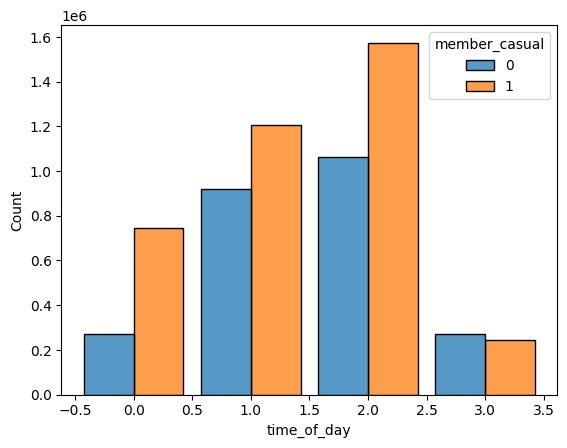

In [25]:
sns.histplot(data=df,x='time_of_day',hue='member_casual',discrete=1,multiple='dodge',shrink=0.85)

A heatmap to quickly look at any correlations in our data.

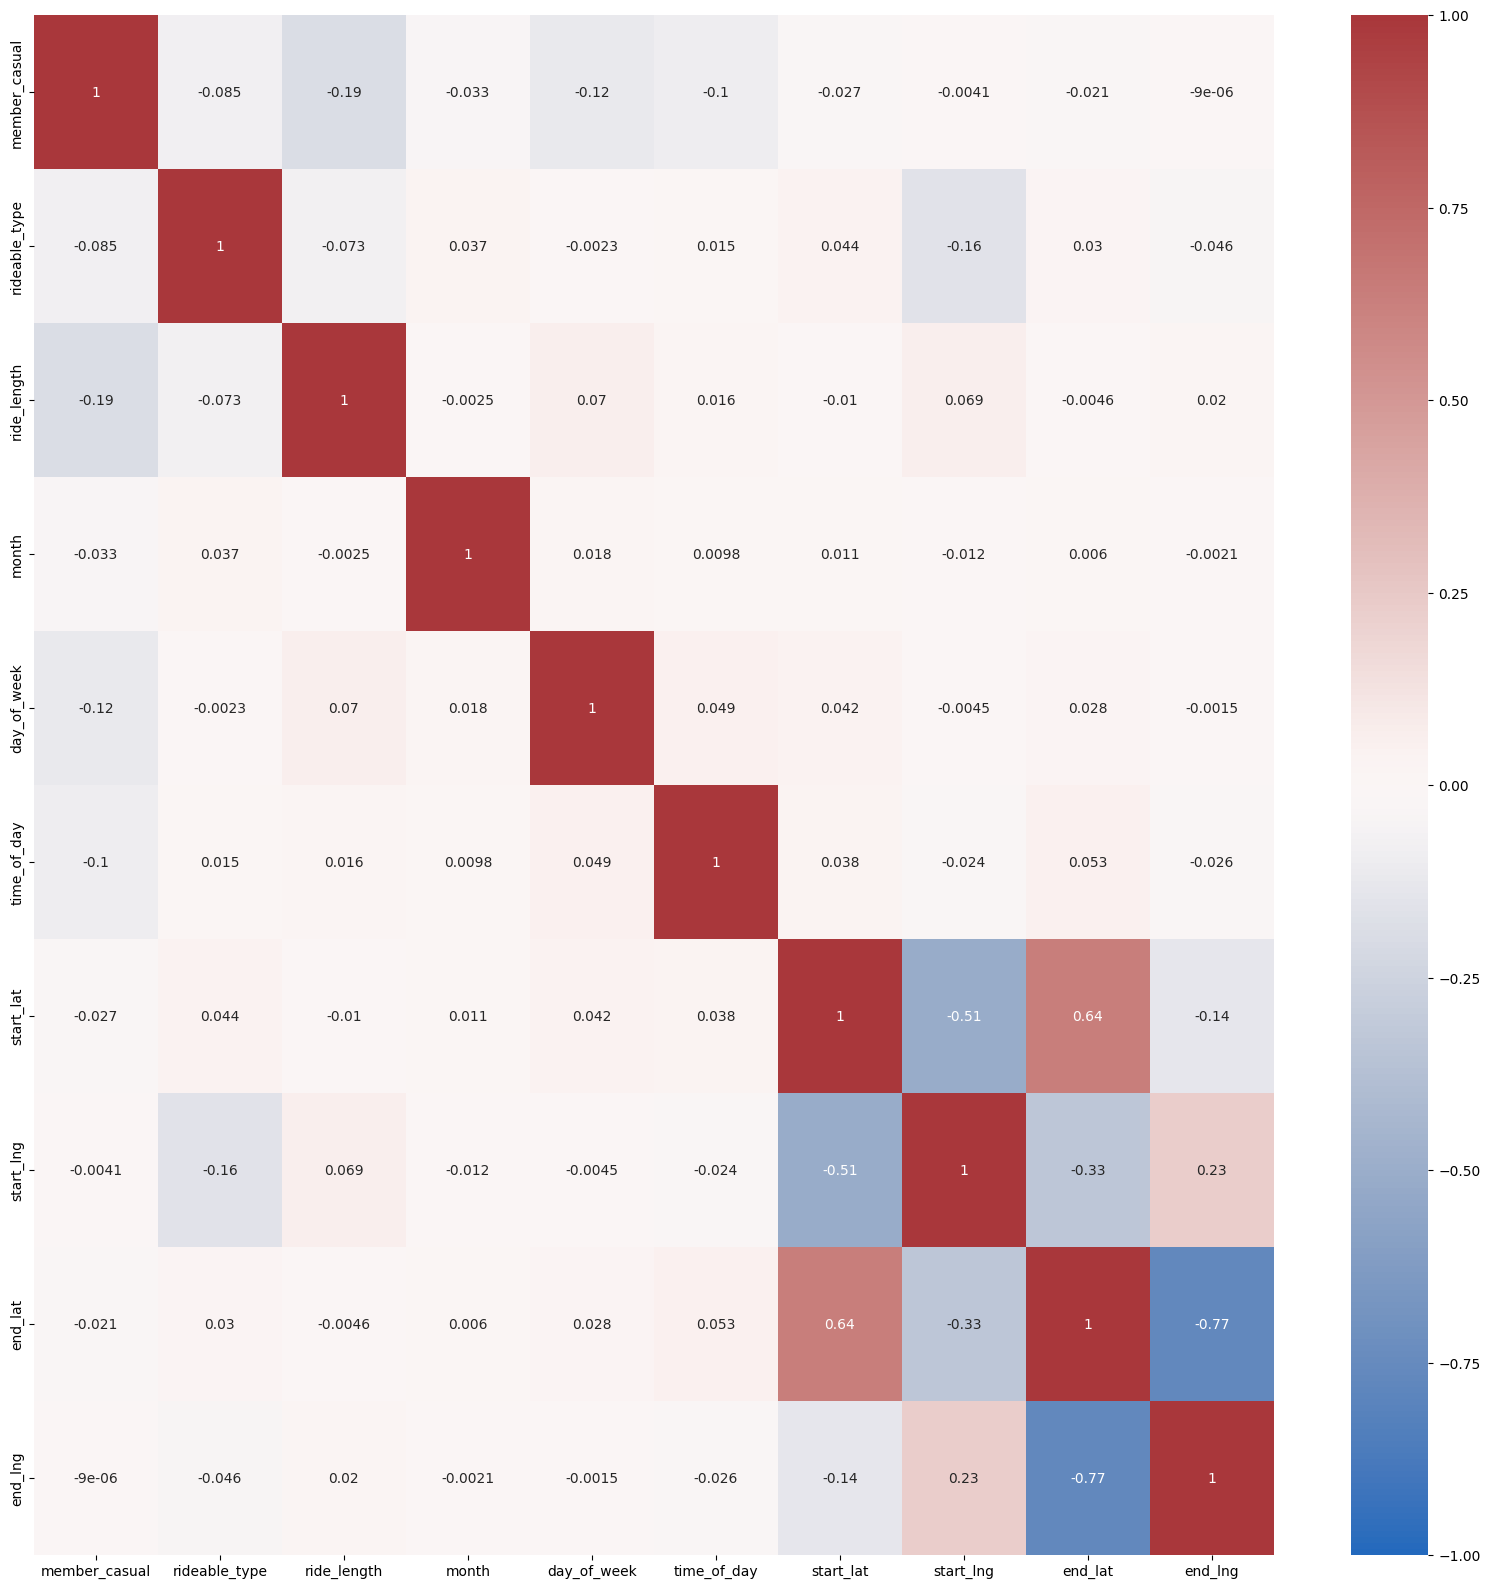

In [26]:
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))

That finishes our data cleaning/processing.
Now we can proceed to building our models.


# Model Building

The target variable we want is the classification of *member_casual*. Let's split our data into training, validation, and testing.

In [3]:
# pd.to_pickle(df,'data.pkl')
df = pd.read_pickle('data.pkl')

In [4]:
y = df['member_casual']
X = df.drop('member_casual',axis=1)

In [29]:
len(df)

6295102

Now let us split our data into training, validation and testing. Since our classes are relatively balanced, we do not need any stratification. I am going for a 98, 1, 1 split between training, validation, and testing due to how large our dataset is. This split lets us be at 99% confidence with margin of error close to 0.5% that our performance on the test set is consistent.

In [5]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.02, random_state=42)

In [6]:
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 42)

In [7]:
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

In [33]:
print(len(X_train), len(X_val), len(X_test))

6169199 62951 62952


In [144]:
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'AUC', 'f-1'])

## Baseline model - Logistic Regression
I will first use a logistic regression model as our baseline.

In [35]:
log_clf = LogisticRegression(random_state=42, max_iter=500)

log_clf.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

Then use the model to make predictions.

In [36]:
y_pred = log_clf.predict(X_val)

Here are the results of our predictions, on a confusion matrix.

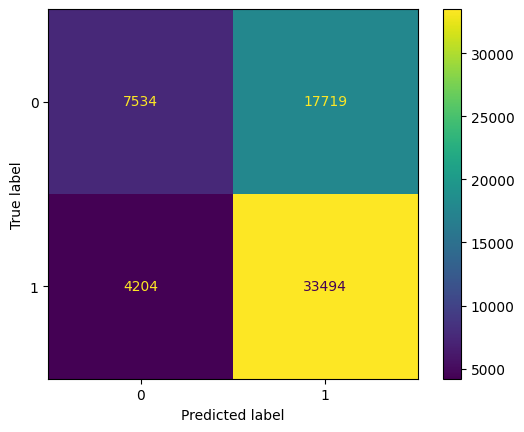

In [37]:
log_cm = confusion_matrix(y_val, y_pred, labels=log_clf.classes_)

log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

plt.show()

In [38]:
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("AUC:", roc_auc_score(y_val, log_clf.decision_function(X_val)))
print("f-1:", f1_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.30      0.41     25253
           1       0.65      0.89      0.75     37698

    accuracy                           0.65     62951
   macro avg       0.65      0.59      0.58     62951
weighted avg       0.65      0.65      0.61     62951

Accuracy: 0.6517450080221124
Precision: 0.6540136293519223
Recall: 0.8884821475940368
AUC: 0.6739173457128056
f-1: 0.753427584888259


In [145]:
results.loc[len(results.index)] = ['Logistic Regression', accuracy_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred), roc_auc_score(y_val, log_clf.decision_function(X_val)), f1_score(y_val, y_pred)]
# pd.to_pickle(results, 'results.pkl')
results

,Model,Accuracy,Precision,Recall,AUC,f-1
0,Logistic Regression,0.651745,0.654014,0.888482,0.673917,0.753428


In [40]:
# pd.to_pickle(log_clf, 'log_reg.pkl')
# log_clf = pd.read_pickle('log_reg.pkl')

The AUC of this model is around 0.6734, which is not great. But, this was our first model, and it serves as a baseline.

The recall score for this model is relatively high, which means it is serviceably good at guessing member rides.

## Naive Bayes
Next, we will explore a Naive Bayes Model.

In [93]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_nb = gnb.predict(X_val)

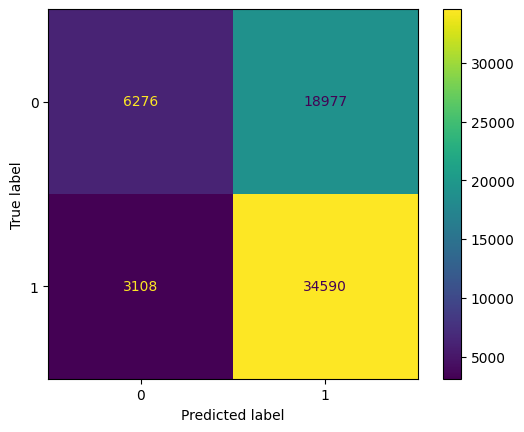

In [94]:
gnb_cm = confusion_matrix(y_val, y_pred_nb, labels=gnb.classes_)

gnb_disp = ConfusionMatrixDisplay(confusion_matrix=gnb_cm, display_labels=gnb.classes_)

# Plot confusion matrix
gnb_disp.plot(values_format='')

plt.show()

In [95]:
print(classification_report(y_val, y_pred_nb))
print("Accuracy:", accuracy_score(y_val, y_pred_nb))
print("Precision:", precision_score(y_val, y_pred_nb))
print("Recall:", recall_score(y_val, y_pred_nb))
print("AUC:", roc_auc_score(y_val, gnb.predict_proba(X_val)[:,1]))
print("f-1:", f1_score(y_val, y_pred_nb))

              precision    recall  f1-score   support

           0       0.67      0.25      0.36     25253
           1       0.65      0.92      0.76     37698

    accuracy                           0.65     62951
   macro avg       0.66      0.58      0.56     62951
weighted avg       0.65      0.65      0.60     62951

Accuracy: 0.6491715778939174
Precision: 0.6457333806261317
Recall: 0.9175553079738978
AUC: 0.6819504566989136
f-1: 0.7580123815263244


In [146]:
results.loc[len(results.index)] = ['Naive Bayes', accuracy_score(y_val, y_pred_nb), precision_score(y_val, y_pred_nb), recall_score(y_val, y_pred_nb), roc_auc_score(y_val, gnb.predict_proba(X_val)[:,1]), f1_score(y_val, y_pred_nb)]
# pd.to_pickle(results, 'results.pkl')
results

,Model,Accuracy,Precision,Recall,AUC,f-1
0,Logistic Regression,0.651745,0.654014,0.888482,0.673917,0.753428
1,Naive Bayes,0.649172,0.645733,0.917555,0.681950,0.758012


In [96]:
# pd.to_pickle(gnb, 'naive_bayes.pkl')

## Decision Trees

Next I will use a Decision Tree Classifier with a Grid Search to find the best hyperparameters, and scored against the AUC.

I will first fit a baseline Decision Tree.

#### Baseline Decision Tree

In [41]:
base_tree = DecisionTreeClassifier(random_state=42)

Now we fit the Decision Tree with the training data.

In [42]:
base_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [43]:
y_pred_tree = base_tree.predict(X_val)

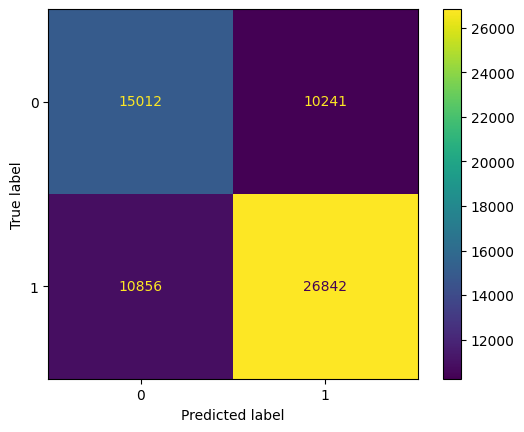

In [44]:
tree_cm = confusion_matrix(y_val, y_pred_tree, labels=base_tree.classes_)

tree_disp = ConfusionMatrixDisplay(confusion_matrix=tree_cm, display_labels=base_tree.classes_)

# Plot confusion matrix
tree_disp.plot(values_format='')

plt.show()

In [45]:
print(classification_report(y_val, y_pred_tree))
print("Accuracy:", accuracy_score(y_val, y_pred_tree))
print("Precision:", precision_score(y_val, y_pred_tree))
print("Recall:", recall_score(y_val, y_pred_tree))
print("AUC:", roc_auc_score(y_val, base_tree.predict_proba(X_val)[:,1]))
print("f-1:", f1_score(y_val, y_pred_tree))

              precision    recall  f1-score   support

           0       0.58      0.59      0.59     25253
           1       0.72      0.71      0.72     37698

    accuracy                           0.66     62951
   macro avg       0.65      0.65      0.65     62951
weighted avg       0.67      0.66      0.67     62951

Accuracy: 0.6648663246016743
Precision: 0.7238357198716393
Recall: 0.7120271632447345
AUC: 0.6533925551344948
f-1: 0.7178828846899614


In [147]:
results.loc[len(results.index)] = ['Baseline Decision Tree', accuracy_score(y_val, y_pred_tree), precision_score(y_val, y_pred_tree), recall_score(y_val, y_pred_tree), roc_auc_score(y_val, base_tree.predict_proba(X_val)[:,1]), f1_score(y_val, y_pred_tree)]
# pd.to_pickle(results, 'results.pkl')
results

,Model,Accuracy,Precision,Recall,AUC,f-1
0,Logistic Regression,0.651745,0.654014,0.888482,0.673917,0.753428
1,Naive Bayes,0.649172,0.645733,0.917555,0.681950,0.758012
2,Baseline Decision Tree,0.664866,0.723836,0.712027,0.653393,0.717883


In [47]:
# pd.to_pickle(base_tree, 'base_tree.pkl')
# base_tree = pd.read_pickle('base_tree.pkl')

This is slightly worse than our baseline logistic regression model. However, this was a baseline for our Decision Trees, and we can search for better hyperparameters for the tree. Below is the structure of the tree's first 3 layers.

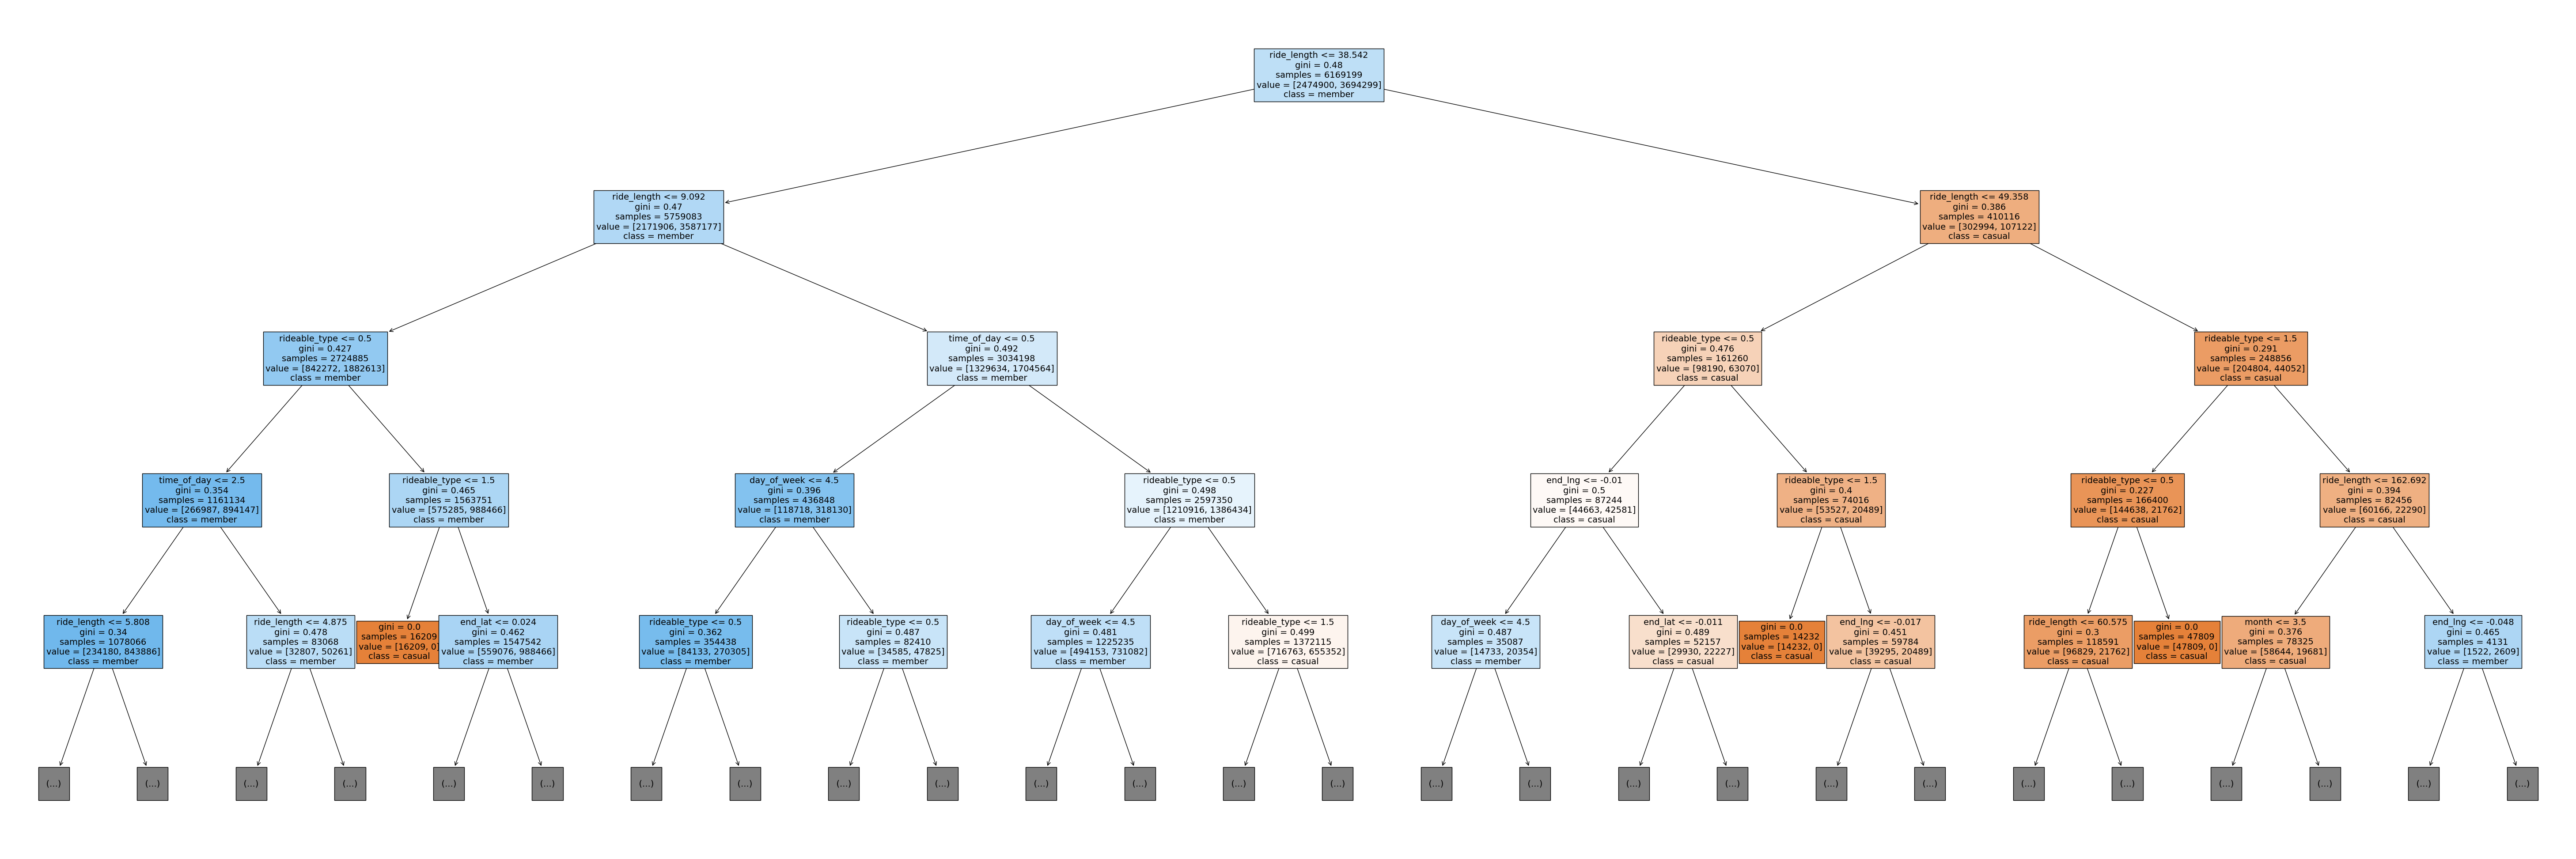

In [127]:
plt.figure(figsize=(75,25))
plot_tree(base_tree, max_depth = 4, fontsize=14, feature_names=list(X.columns), filled=True, class_names=['casual', 'member'])
plt.show()

In [129]:
base_tree_importances = pd.DataFrame(base_tree.feature_importances_, columns=['gini_importance'], index=X_train.columns)
base_tree_importances = base_tree_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
base_tree_importances = base_tree_importances[base_tree_importances['gini_importance'] != 0]
base_tree_importances

,gini_importance
ride_length,0.288440
start_lat,0.144628
start_lng,0.144550
end_lat,0.109167
end_lng,0.106659
month,0.067329
day_of_week,0.059775
rideable_type,0.040700
time_of_day,0.038752


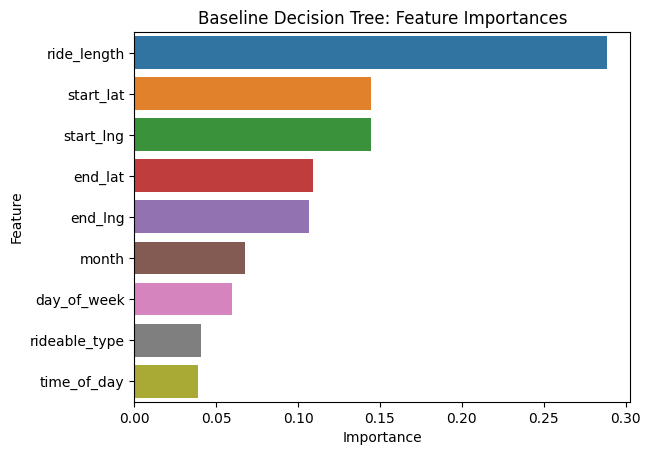

In [130]:
sns.barplot(data=base_tree_importances, x="gini_importance", y=base_tree_importances.index, orient='h')
plt.title("Baseline Decision Tree: Feature Importances", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

#### Hyperparameter Tuning

In [49]:
tree_2 = DecisionTreeClassifier(random_state=42)

params = {'max_depth':[8, None],
          'max_features': [None, 'sqrt'],
          'min_samples_leaf': [10, 25, 40],
          'min_samples_split': [4, 10, 16]}

test_fold = [0 if x in X_val.index else -1 for x in X_train_val.index]

ps = PredefinedSplit(test_fold = test_fold)

gridsearch_val = GridSearchCV(tree_2, params, scoring='roc_auc', cv = ps, refit=False, verbose=4)

In [50]:
gridsearch_val.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV 1/1] END max_depth=8, max_features=None, min_samples_leaf=10, min_samples_split=4;, score=0.709 total time=  60.0s
[CV 1/1] END max_depth=8, max_features=None, min_samples_leaf=10, min_samples_split=10;, score=0.709 total time=  59.8s
[CV 1/1] END max_depth=8, max_features=None, min_samples_leaf=10, min_samples_split=16;, score=0.709 total time=  59.9s
[CV 1/1] END max_depth=8, max_features=None, min_samples_leaf=25, min_samples_split=4;, score=0.709 total time= 1.0min
[CV 1/1] END max_depth=8, max_features=None, min_samples_leaf=25, min_samples_split=10;, score=0.709 total time= 1.1min
[CV 1/1] END max_depth=8, max_features=None, min_samples_leaf=25, min_samples_split=16;, score=0.709 total time= 1.0min
[CV 1/1] END max_depth=8, max_features=None, min_samples_leaf=40, min_samples_split=4;, score=0.709 total time= 1.0min
[CV 1/1] END max_depth=8, max_features=None, min_samples_leaf=40, min_samples_split=10;, score=0.709 t

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [8, None], 'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [10, 25, 40],
                         'min_samples_split': [4, 10, 16]},
             refit=False, scoring='roc_auc', verbose=4)

In [51]:
gridsearch_val.best_score_

0.7527252855145926

In [52]:
gridsearch_val.best_params_

{'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 40,
 'min_samples_split': 4}

In [53]:
gridsearch_val.cv_results_

{'mean_fit_time': array([ 60.05272031,  59.8376174 ,  59.94218564,  61.96566677,
         63.32452583,  61.52341938,  62.68716598,  63.85359287,
         64.27907205,  29.60965037,  29.35997438,  31.89396691,
         35.24994636,  32.23246646,  32.97599483,  32.59667969,
         35.21491289,  35.80274773, 216.28587294, 225.44995832,
        223.15830517, 213.14947867, 197.76812649, 182.40510106,
        211.35740495, 247.22878265, 222.04737425,  93.57390261,
         93.09795618,  98.97050214,  88.53790689,  87.7766943 ,
         88.16665936,  88.06445813,  87.05422521,  87.67327762]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 'mean_score_time': array([0.02892613, 0.0259304 , 0.02393579, 0.02590322, 0.03091216,
        0.02194142, 0.02592993, 0.03291512, 0.03191471, 0.03394032,
        0.02992296, 0.03390265, 0.03491116, 0.03589797, 0.034936

We notice that the *min_samples_split* parameter does not impact the scoring.

In [54]:
# pd.to_pickle(gridsearch_val, 'gs_val.pkl')

#### Second Round of Hyperparameter Tuning
Seeing that the *min_samples_split* parameter is not impactful, that the model performs better as the *min_samples_leaf* parameter increases, and that our model performs best with no limit to *max_depth* and *max_features*, we perform a second round of hyperparameter tuning, specifically on the *min_samples_leaf* parameter to find the best parameter.

In [93]:
tree_3 = DecisionTreeClassifier(random_state=42)

params = {'max_depth':[None],
          'max_features': [None],
          'min_samples_leaf': [40, 50, 60, 70, 80]}

test_fold = [0 if x in X_val.index else -1 for x in X_train_val.index]

ps = PredefinedSplit(test_fold = test_fold)

gridsearch_val2 = GridSearchCV(tree_3, params, scoring='roc_auc', cv = ps, refit=False, verbose=4)

In [56]:
gridsearch_val2.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END max_depth=None, max_features=None, min_samples_leaf=40;, score=0.753 total time= 3.5min
[CV 1/1] END max_depth=None, max_features=None, min_samples_leaf=50;, score=0.755 total time= 3.4min
[CV 1/1] END max_depth=None, max_features=None, min_samples_leaf=60;, score=0.753 total time= 3.0min
[CV 1/1] END max_depth=None, max_features=None, min_samples_leaf=70;, score=0.753 total time= 2.7min
[CV 1/1] END max_depth=None, max_features=None, min_samples_leaf=80;, score=0.754 total time= 3.1min


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [None],
                         'min_samples_leaf': [40, 50, 60, 70, 80]},
             refit=False, scoring='roc_auc', verbose=4)

In [57]:
gridsearch_val2.best_score_

0.7545373448427523

In [58]:
gridsearch_val2.cv_results_

{'mean_fit_time': array([209.79822731, 206.02494216, 180.13054109, 164.57808995,
        184.39194179]),
 'std_fit_time': array([0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.09175658, 0.07779574, 0.05284786, 0.07676148, 0.10970831]),
 'std_score_time': array([0., 0., 0., 0., 0.]),
 'param_max_depth': masked_array(data=[None, None, None, None, None],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[None, None, None, None, None],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[40, 50, 60, 70, 80],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': None, 'max_features': None, 'min_samples_leaf': 40},
  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 50},
  {'max_depth': None, 'max_fea

In [59]:
gridsearch_val2.best_params_

{'max_depth': None, 'max_features': None, 'min_samples_leaf': 50}

In [60]:
# pd.to_pickle(gridsearch_val2, 'gs_val2.pkl')

In [61]:
opt_tree = DecisionTreeClassifier(random_state=42, max_depth=None, max_features=None, min_samples_leaf=50)

opt_tree.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=50, random_state=42)

In [62]:
y_pred_opt_tree = opt_tree.predict(X_val)

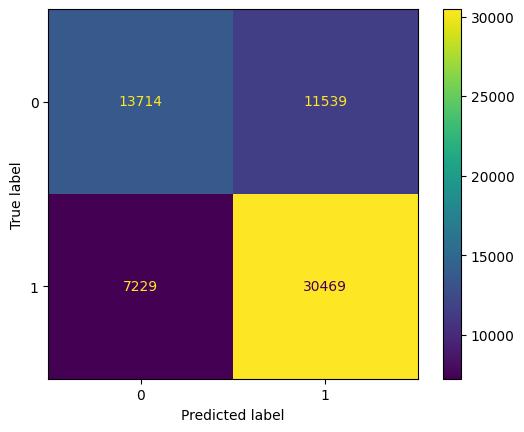

In [63]:
opt_tree_cm = confusion_matrix(y_val, y_pred_opt_tree, labels=opt_tree.classes_)

opt_tree_disp = ConfusionMatrixDisplay(confusion_matrix=opt_tree_cm, display_labels=opt_tree.classes_)

# Plot confusion matrix
opt_tree_disp.plot(values_format='')

plt.show()

In [64]:
print(classification_report(y_val, y_pred_opt_tree))
print("Accuracy:", accuracy_score(y_val, y_pred_opt_tree))
print("Precision:", precision_score(y_val, y_pred_opt_tree))
print("Recall:", recall_score(y_val, y_pred_opt_tree))
print("AUC:", roc_auc_score(y_val, opt_tree.predict_proba(X_val)[:,1]))
print("f-1:", f1_score(y_val, y_pred_opt_tree))

              precision    recall  f1-score   support

           0       0.65      0.54      0.59     25253
           1       0.73      0.81      0.76     37698

    accuracy                           0.70     62951
   macro avg       0.69      0.68      0.68     62951
weighted avg       0.70      0.70      0.70     62951

Accuracy: 0.7018633540372671
Precision: 0.7253142258617407
Recall: 0.8082391638813731
AUC: 0.7545373448427523
f-1: 0.7645346648934835


In [148]:
results.loc[len(results.index)] = ['Tuned Decision Tree', accuracy_score(y_val, y_pred_opt_tree), precision_score(y_val, y_pred_opt_tree), recall_score(y_val, y_pred_opt_tree), roc_auc_score(y_val, opt_tree.predict_proba(X_val)[:,1]), f1_score(y_val, y_pred_opt_tree)]
# pd.to_pickle(results, 'results.pkl')
results

,Model,Accuracy,Precision,Recall,AUC,f-1
0,Logistic Regression,0.651745,0.654014,0.888482,0.673917,0.753428
1,Naive Bayes,0.649172,0.645733,0.917555,0.681950,0.758012
2,Baseline Decision Tree,0.664866,0.723836,0.712027,0.653393,0.717883
3,Tuned Decision Tree,0.701863,0.725314,0.808239,0.754537,0.764535


In [66]:
# pd.to_pickle(opt_tree, 'opt_tree.pkl')
# opt_tree = pd.read_pickle('opt_tree.pkl')

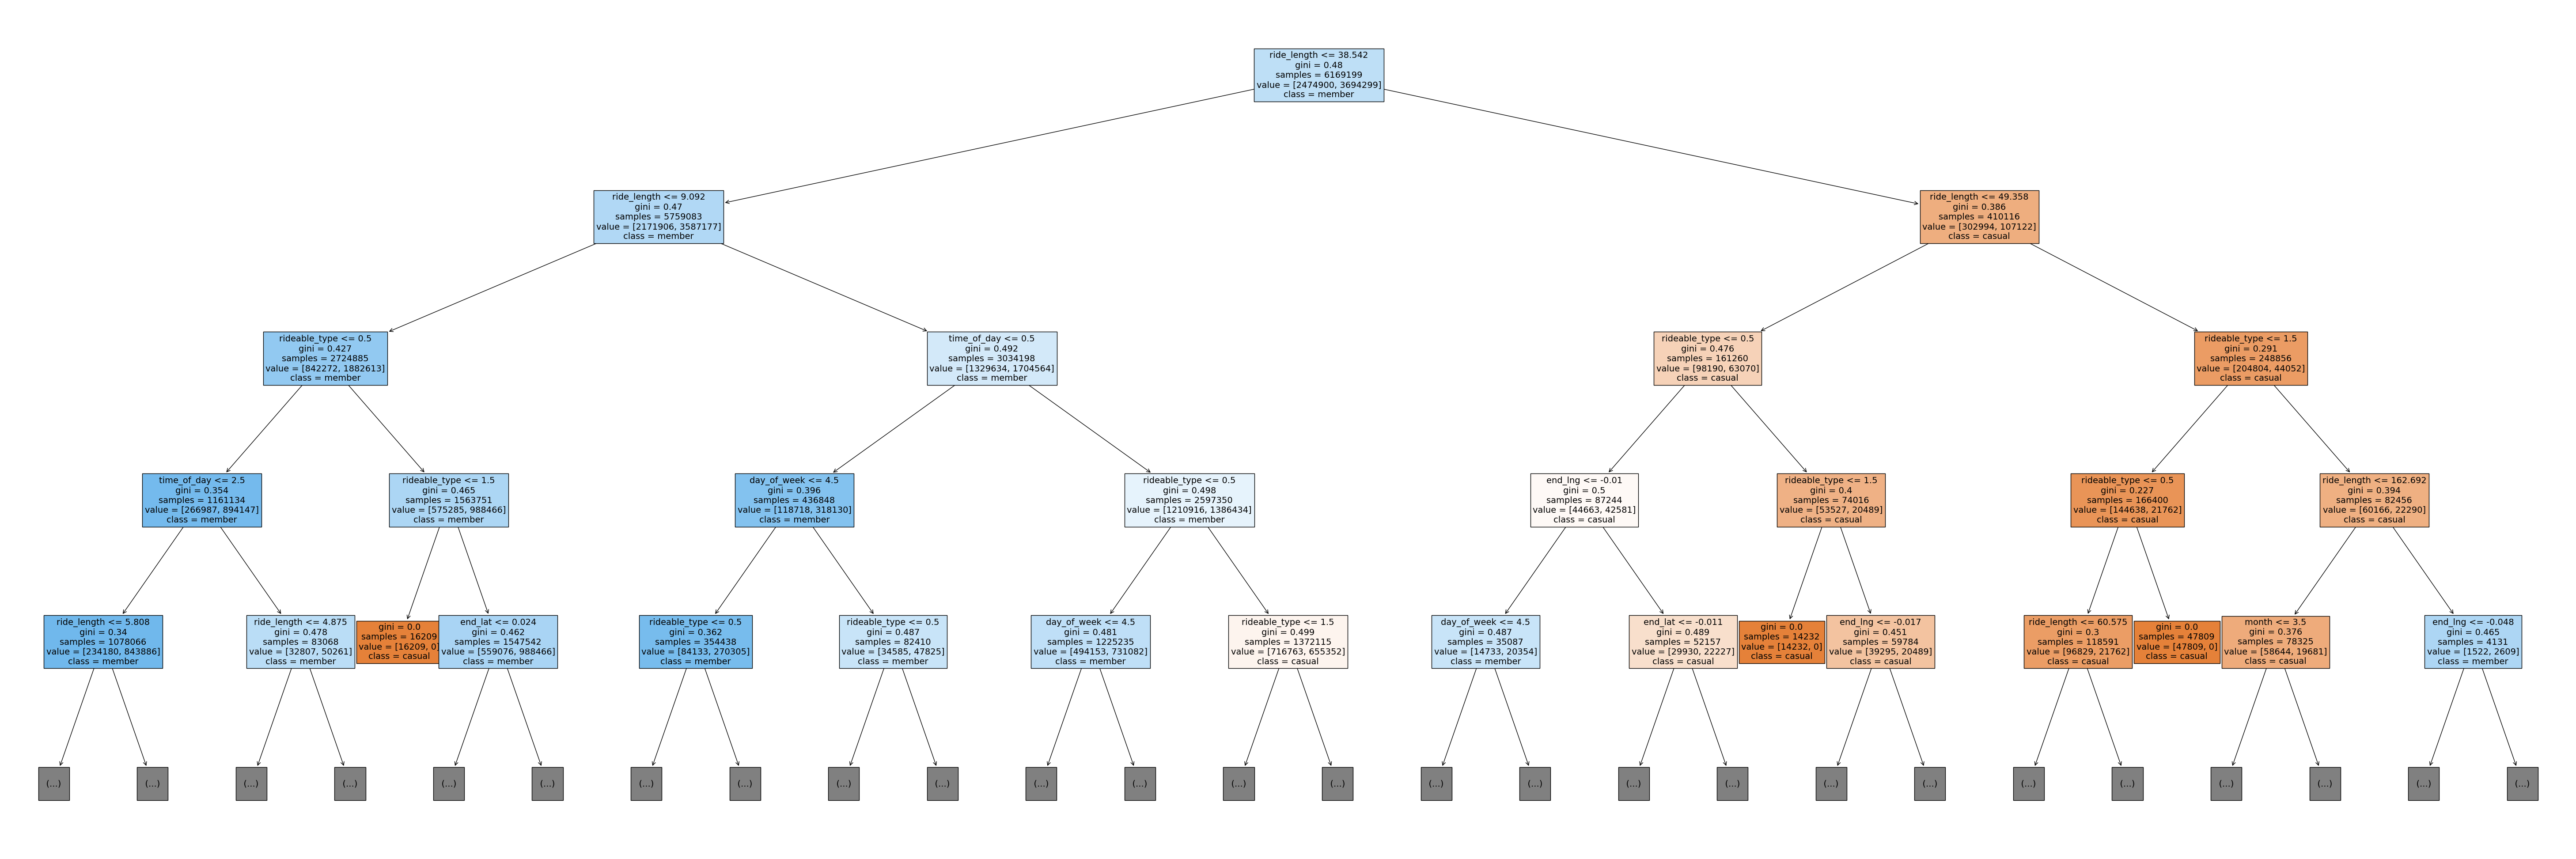

In [67]:
plt.figure(figsize=(75,25))
plot_tree(opt_tree, max_depth = 4, fontsize=14, feature_names=list(X.columns), filled=True, class_names=['casual', 'member'])
plt.show()

In [131]:
opt_tree_importances = pd.DataFrame(opt_tree.feature_importances_, columns=['gini_importance'], index=X_train.columns)
opt_tree_importances = opt_tree_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
opt_tree_importances = opt_tree_importances[opt_tree_importances['gini_importance'] != 0]
opt_tree_importances

,gini_importance
ride_length,0.266735
rideable_type,0.144334
end_lat,0.110523
start_lat,0.104956
start_lng,0.104107
end_lng,0.101117
month,0.064097
time_of_day,0.061723
day_of_week,0.042409


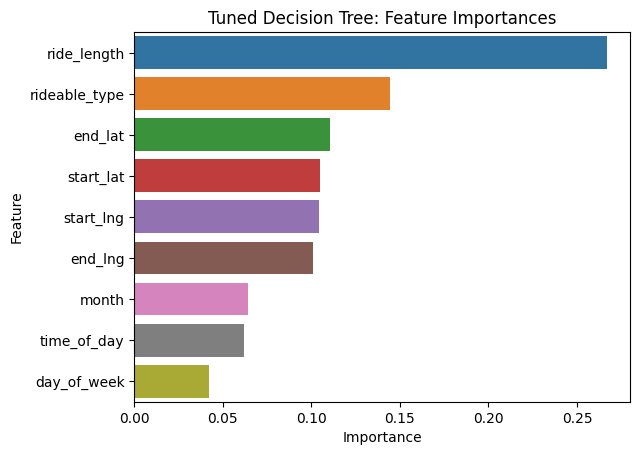

In [132]:
sns.barplot(data=opt_tree_importances, x="gini_importance", y=opt_tree_importances.index, orient='h')
plt.title("Tuned Decision Tree: Feature Importances", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

## Random Forest
Next we will examine and tune Random Forest models.
We will go straight to finding the best hyperparameters for a Random Forest.

In [84]:
rf = RandomForestClassifier(random_state=42)
params = {'n_estimators': [10, 15, 20],
          'max_depth':[None],
          'max_samples': [0.1, 0.2, 0.3]}

test_fold = [0 if x in X_val.index else -1 for x in X_train_val.index]

ps = PredefinedSplit(test_fold = test_fold)

gridsearch_rf_val = GridSearchCV(rf, params, scoring='roc_auc', cv = ps, refit=False, verbose=4)

In [85]:
gridsearch_rf_val.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV 1/1] END max_depth=None, max_samples=0.1, n_estimators=10;, score=0.743 total time= 1.9min
[CV 1/1] END max_depth=None, max_samples=0.1, n_estimators=15;, score=0.757 total time= 2.8min
[CV 1/1] END max_depth=None, max_samples=0.1, n_estimators=20;, score=0.765 total time= 3.7min
[CV 1/1] END max_depth=None, max_samples=0.2, n_estimators=10;, score=0.753 total time= 3.5min
[CV 1/1] END max_depth=None, max_samples=0.2, n_estimators=15;, score=0.768 total time= 5.4min
[CV 1/1] END max_depth=None, max_samples=0.2, n_estimators=20;, score=0.775 total time= 7.0min
[CV 1/1] END max_depth=None, max_samples=0.3, n_estimators=10;, score=0.759 total time= 5.8min
[CV 1/1] END max_depth=None, max_samples=0.3, n_estimators=15;, score=0.772 total time= 8.3min
[CV 1/1] END max_depth=None, max_samples=0.3, n_estimators=20;, score=0.780 total time= 9.2min


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_samples': [0.1, 0.2, 0.3],
                         'n_estimators': [10, 15, 20]},
             refit=False, scoring='roc_auc', verbose=4)

In [86]:
# pd.to_pickle(gridsearch_rf_val, 'gs_rf_val.pkl')

In [87]:
params = {'n_estimators': [20, 40, 80],
          'max_depth':[None],
          'max_samples': [0.3]}

gridsearch_rf_val_2 = GridSearchCV(rf, params, scoring='roc_auc', cv = ps, refit=False, verbose=4)

In [88]:
gridsearch_rf_val_2.fit(X_train_val,y_train_val)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END max_depth=None, max_samples=0.3, n_estimators=20;, score=0.780 total time= 8.3min
[CV 1/1] END max_depth=None, max_samples=0.3, n_estimators=40;, score=0.792 total time=19.2min
[CV 1/1] END max_depth=None, max_samples=0.3, n_estimators=80;, score=0.799 total time=70.5min


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_samples': [0.3],
                         'n_estimators': [20, 40, 80]},
             refit=False, scoring='roc_auc', verbose=4)

In [89]:
# pd.to_pickle(gridsearch_rf_val_2, 'gs_rf_val2.pkl')

In [91]:
gridsearch_rf_val_2.best_score_

0.7991813121253762

In [92]:
gridsearch_rf_val_2.cv_results_

{'mean_fit_time': array([ 496.64648056, 1148.87013769, 4192.38446307]),
 'std_fit_time': array([0., 0., 0.]),
 'mean_score_time': array([ 1.24765062,  2.15170717, 38.89400172]),
 'std_score_time': array([0., 0., 0.]),
 'param_max_depth': masked_array(data=[None, None, None],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_samples': masked_array(data=[0.3, 0.3, 0.3],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[20, 40, 80],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': None, 'max_samples': 0.3, 'n_estimators': 20},
  {'max_depth': None, 'max_samples': 0.3, 'n_estimators': 40},
  {'max_depth': None, 'max_samples': 0.3, 'n_estimators': 80}],
 'split0_test_score': array([0.77969016, 0.79229586, 0.79918131]),
 'mean_test_score': array([0.77969016, 0.79229586, 0.79918131])

In [109]:
random_forest = RandomForestClassifier(random_state=42, max_depth=None, max_samples = 0.3, n_estimators=80)

In [110]:
random_forest.fit(X_train,y_train)

RandomForestClassifier(max_samples=0.3, n_estimators=80, random_state=42)

In [115]:
y_pred_random_forest = random_forest.predict(X_val)


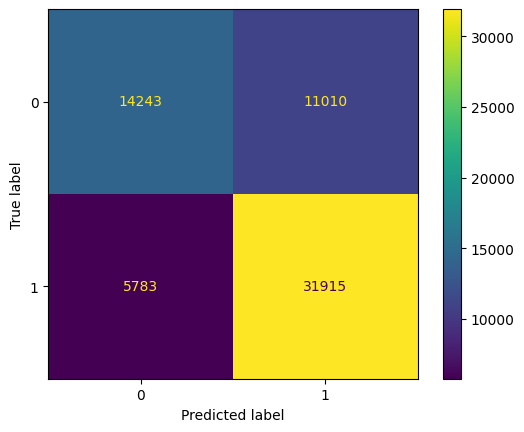

In [116]:
random_forest_cm = confusion_matrix(y_val, y_pred_random_forest, labels=random_forest.classes_)

random_forest_disp = ConfusionMatrixDisplay(confusion_matrix=random_forest_cm, display_labels=random_forest.classes_)

# Plot confusion matrix
random_forest_disp.plot(values_format='')

plt.show()

In [117]:
print(classification_report(y_val, y_pred_random_forest))
print("Accuracy:", accuracy_score(y_val, y_pred_random_forest))
print("Precision:", precision_score(y_val, y_pred_random_forest))
print("Recall:", recall_score(y_val, y_pred_random_forest))
print("AUC:", roc_auc_score(y_val, random_forest.predict_proba(X_val)[:,1]))
print("f-1:", f1_score(y_val, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.71      0.56      0.63     25253
           1       0.74      0.85      0.79     37698

    accuracy                           0.73     62951
   macro avg       0.73      0.71      0.71     62951
weighted avg       0.73      0.73      0.73     62951

Accuracy: 0.733236962081619
Precision: 0.7435061153174141
Recall: 0.8465966364263356
AUC: 0.7991813121253762
f-1: 0.7917095617875792


In [149]:
results.loc[len(results.index)] = ['Tuned Random Forest', accuracy_score(y_val, y_pred_random_forest), precision_score(y_val, y_pred_random_forest), recall_score(y_val, y_pred_random_forest), roc_auc_score(y_val, random_forest.predict_proba(X_val)[:,1]), f1_score(y_val, y_pred_random_forest)]
# pd.to_pickle(results, 'results.pkl')
results

,Model,Accuracy,Precision,Recall,AUC,f-1
0,Logistic Regression,0.651745,0.654014,0.888482,0.673917,0.753428
1,Naive Bayes,0.649172,0.645733,0.917555,0.681950,0.758012
2,Baseline Decision Tree,0.664866,0.723836,0.712027,0.653393,0.717883
3,Tuned Decision Tree,0.701863,0.725314,0.808239,0.754537,0.764535
4,Tuned Random Forest,0.733237,0.743506,0.846597,0.799181,0.791710


In [123]:
# pd.to_pickle(random_forest,'random_forest.pkl')

In [134]:
#tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns=X.columns)
rf_importances = pd.DataFrame(random_forest.feature_importances_, columns=['gini_importance'], index=X_train.columns)
rf_importances = rf_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
rf_importances = rf_importances[rf_importances['gini_importance'] != 0]
rf_importances

,gini_importance
ride_length,0.250000
start_lng,0.148954
start_lat,0.148154
end_lng,0.124371
end_lat,0.123646
month,0.072021
day_of_week,0.058999
rideable_type,0.038188
time_of_day,0.035668


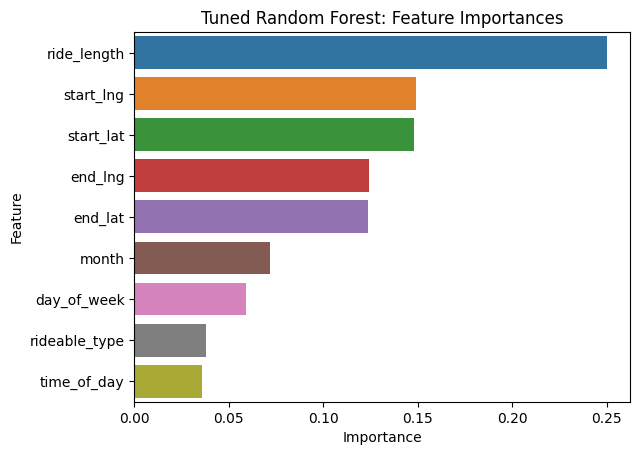

In [135]:
sns.barplot(data=rf_importances, x="gini_importance", y=rf_importances.index, orient='h')
plt.title("Tuned Random Forest: Feature Importances", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

## Gradient Boosting

Now we will build Gradient Boosted Models, first using XGBoost, then using LightGBM.

### XGBoost

In [158]:
xgb = XGBClassifier(objective='binary:logistic', random_state = 42)

params = {'n_estimators': [20, 60, 100],
          'max_depth': [6, 10],
          'min_child_weight': [3, 5],
          'learning_rate': [0.1, 0.2, 0.3],
          'subsample': [0.7],
          'colsample_bytree': [0.7]}

test_fold = [0 if x in X_val.index else -1 for x in X_train_val.index]

ps = PredefinedSplit(test_fold = test_fold)

gridsearch_xgb_val = GridSearchCV(xgb, params, scoring='roc_auc', cv = ps, refit=False, verbose=4)

In [159]:
gridsearch_xgb_val.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, subsample=0.7;, score=0.731 total time= 1.1min
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=60, subsample=0.7;, score=0.746 total time= 3.8min
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.7;, score=0.752 total time= 7.1min
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=20, subsample=0.7;, score=0.731 total time= 1.5min
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=60, subsample=0.7;, score=0.745 total time= 4.3min
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=100, subsample=0.7;, score=0.752 total time= 6.9min
[CV 1/1] END colsample_bytree=0

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [6, 10],
                         'min_child_weight': [3, 5],
                         'n_estimators': [20, 60, 100], 'subsample': [0.7]},
             refit=False, scoring='roc_auc', verbose=4)

In [160]:
pd.to_pickle(gridsearch_xgb_val, 'gs_xgb.pkl')

In [8]:
xgb = XGBClassifier(objective='binary:logistic', random_state = 42)

params = {'n_estimators': [100, 150, 200],
          'max_depth': [10],
          'learning_rate': [0.1, 0.2, 0.3],
          'subsample': [0.7],
          'colsample_bytree': [0.7]}

test_fold = [0 if x in X_val.index else -1 for x in X_train_val.index]

ps = PredefinedSplit(test_fold = test_fold)

gridsearch_xgb_val_2 = GridSearchCV(xgb, params, scoring='roc_auc', cv = ps, refit=False, verbose=4)

In [9]:
gridsearch_xgb_val_2.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.7;, score=0.772 total time= 5.2min
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.779 total time= 9.6min
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.7;, score=0.784 total time=14.3min
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=100, subsample=0.7;, score=0.783 total time= 7.5min
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.789 total time=11.0min
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=200, subsample=0.7;, score=0.792 total time=14.8min
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=100, subsample=0.7;, score=0.787 total time= 6.3min
[CV 1/1] E

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [10],
                         'n_estimators': [100, 150, 200], 'subsample': [0.7]},
             refit=False, scoring='roc_auc', verbose=4)

In [12]:
gridsearch_xgb_val_2.cv_results_

{'mean_fit_time': array([309.53542757, 578.03241897, 857.88550973, 447.45729995,
        660.35776591, 890.16532683, 379.60909438, 648.76429796,
        855.42795372]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.21043682, 0.24235153, 0.30916429, 0.19096756, 0.24430919,
        0.29421449, 0.17553163, 0.22440028, 0.32911897]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'param_colsample_bytree': masked_array(data=[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[10, 10, 10, 10, 10, 10, 10, 

In [15]:
xgb = XGBClassifier(objective='binary:logistic', random_state = 42)

params = {'n_estimators': [300, 400, 500],
          'max_depth': [10],
          'learning_rate': [0.3],
          'subsample': [0.7],
          'colsample_bytree': [0.7]}

test_fold = [0 if x in X_val.index else -1 for x in X_train_val.index]

ps = PredefinedSplit(test_fold = test_fold)

gridsearch_xgb_val_3 = GridSearchCV(xgb, params, scoring='roc_auc', cv = ps, refit=False, verbose=4)

In [16]:
gridsearch_xgb_val_3.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=300, subsample=0.7;, score=0.797 total time=24.8min
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=400, subsample=0.7;, score=0.799 total time=30.1min
[CV 1/1] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=500, subsample=0.7;, score=0.801 total time=39.2min


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.3],
                         'max_depth': [10], 'n_estimators': [300, 400, 500],
                         'subsample': [0.7]},
             refit=False, scoring='roc_auc', verbose=4)

In [18]:
gridsearch_xgb_val_3.cv_results_

{'mean_fit_time': array([1489.48560619, 1803.278126  , 2352.45065165]),
 'std_fit_time': array([0., 0., 0.]),
 'mean_score_time': array([0.36901379, 0.58942151, 0.72505999]),
 'std_score_time': array([0., 0., 0.]),
 'param_colsample_bytree': masked_array(data=[0.7, 0.7, 0.7],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.3, 0.3, 0.3],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[10, 10, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[300, 400, 500],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.7, 0.7, 0.7],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'colsample_bytre

In [21]:
tuned_xgb = XGBClassifier(n_estimators=500, max_depth=10, subsample=0.7, colsample_bytree=0.7, learning_rate=0.3, objective='binary:logistic', random_state = 42)

In [22]:
tuned_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [23]:
y_pred_xgb = tuned_xgb.predict(X_val)

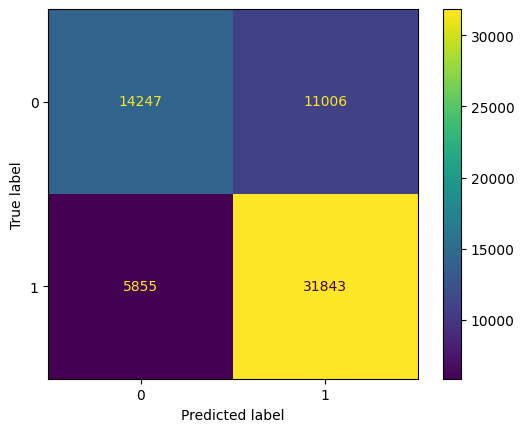

In [24]:
xgb_cm = confusion_matrix(y_val, y_pred_xgb, labels=tuned_xgb.classes_)

xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=tuned_xgb.classes_)

# Plot confusion matrix
xgb_disp.plot(values_format='')

plt.show()

In [25]:
print(classification_report(y_val, y_pred_xgb))
print("Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("Precision:", precision_score(y_val, y_pred_xgb))
print("Recall:", recall_score(y_val, y_pred_xgb))
print("AUC:", roc_auc_score(y_val, tuned_xgb.predict_proba(X_val)[:,1]))
print("f-1:", f1_score(y_val, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.71      0.56      0.63     25253
           1       0.74      0.84      0.79     37698

    accuracy                           0.73     62951
   macro avg       0.73      0.70      0.71     62951
weighted avg       0.73      0.73      0.73     62951

Accuracy: 0.7321567568426236
Precision: 0.7431445307941842
Recall: 0.8446867207809433
AUC: 0.8006901873555299
f-1: 0.7906688020658745


In [27]:
results.loc[len(results.index)] = ['XGBoost', accuracy_score(y_val, y_pred_xgb), precision_score(y_val, y_pred_xgb), recall_score(y_val, y_pred_xgb), roc_auc_score(y_val, tuned_xgb.predict_proba(X_val)[:,1]), f1_score(y_val, y_pred_xgb)]
# pd.to_pickle(results, 'results.pkl')
results

,Model,Accuracy,Precision,Recall,AUC,f-1
0,Logistic Regression,0.651745,0.654014,0.888482,0.673917,0.753428
1,Naive Bayes,0.649172,0.645733,0.917555,0.681950,0.758012
2,Baseline Decision Tree,0.664866,0.723836,0.712027,0.653393,0.717883
3,Tuned Decision Tree,0.701863,0.725314,0.808239,0.754537,0.764535
4,Tuned Random Forest,0.733237,0.743506,0.846597,0.799181,0.791710
5,XGBoost,0.732157,0.743145,0.844687,0.800690,0.790669


In [29]:
# pd.to_pickle(tuned_xgb,'xgb.pkl')

In [36]:
xgb_importances = pd.DataFrame(tuned_xgb.feature_importances_, columns=['gini_importance'], index=X_train.columns)
xgb_importances = xgb_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
xgb_importances = xgb_importances[xgb_importances['gini_importance'] != 0]
xgb_importances

,gini_importance
rideable_type,0.450768
ride_length,0.078740
time_of_day,0.077712
end_lat,0.076056
end_lng,0.069998
start_lat,0.063945
start_lng,0.062781
month,0.062669
day_of_week,0.057333


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

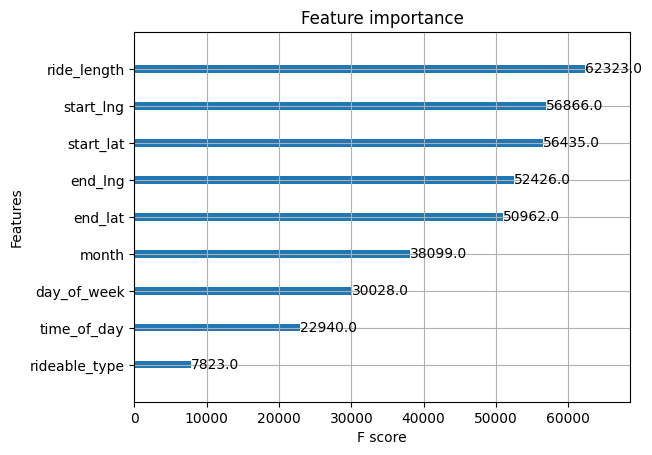

In [40]:
xgboost.plot_importance(tuned_xgb)

This plot above is plotting F-score, which is a count on how often the trees split based on this metric. The feature importance graph based on gini is shown below.

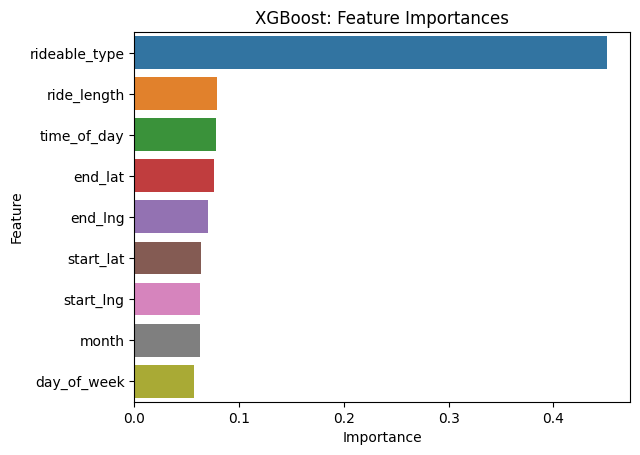

In [38]:
sns.barplot(data=xgb_importances, x="gini_importance", y=xgb_importances.index, orient='h')
plt.title("XGBoost: Feature Importances", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

### LightGBM


#### Baseline
I will use the same parameters as the tuned XGBoost model, but with LightGBM to serve as a baseline.

In [64]:
base_lgbm = LGBMClassifier(n_estimators=500, max_depth=10, subsample=0.7, colsample_bytree=0.7, learning_rate=0.3, objective='binary', random_state = 42)
base_lgbm.fit(X_train, y_train, eval_set=(X_val, y_val), eval_metric='auc')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3694299, number of negative: 2474900
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.404613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1302
[LightGBM] [Info] Number of data points in the train set: 6169199, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598830 -> initscore=0.400591
[LightGBM] [Info] Start training from score 0.400591


LGBMClassifier(colsample_bytree=0.7, learning_rate=0.3, max_depth=10,
               n_estimators=500, objective='binary', random_state=42,
               subsample=0.7)

In [69]:
base_lgbm.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('auc', 0.7770553872364854),
                          ('binary_logloss', 0.5416792270193564)])})

In [66]:
y_pred_lgb = base_lgbm.predict(X_val)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


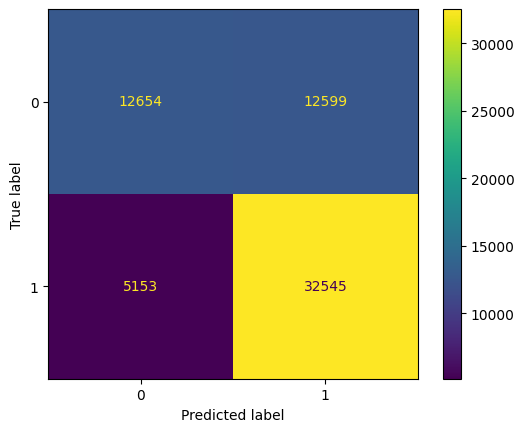

In [67]:
base_lgb_cm = confusion_matrix(y_val, y_pred_lgb, labels=base_lgbm.classes_)

base_lgb_disp = ConfusionMatrixDisplay(confusion_matrix=base_lgb_cm, display_labels=base_lgbm.classes_)

# Plot confusion matrix
base_lgb_disp.plot(values_format='')

plt.show()

In [68]:
print(classification_report(y_val, y_pred_lgb))
print("Accuracy:", accuracy_score(y_val, y_pred_lgb))
print("Precision:", precision_score(y_val, y_pred_lgb))
print("Recall:", recall_score(y_val, y_pred_lgb))
print("AUC:", roc_auc_score(y_val, base_lgbm.predict_proba(X_val)[:,1]))
print("f-1:", f1_score(y_val, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.71      0.50      0.59     25253
           1       0.72      0.86      0.79     37698

    accuracy                           0.72     62951
   macro avg       0.72      0.68      0.69     62951
weighted avg       0.72      0.72      0.71     62951

Accuracy: 0.7180028911375514
Precision: 0.7209152932837143
Recall: 0.8633083983235185
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC: 0.7770553872364854
f-1: 0.7857125612611959


In [81]:
results.loc[len(results.index)] = ['Baseline LGB', accuracy_score(y_val, y_pred_lgb), precision_score(y_val, y_pred_lgb), recall_score(y_val, y_pred_lgb), roc_auc_score(y_val, base_lgbm.predict_proba(X_val)[:,1]), f1_score(y_val, y_pred_lgb)]
# pd.to_pickle(results, 'results.pkl')
results

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,Model,Accuracy,Precision,Recall,AUC,f-1
0,Logistic Regression,0.651745,0.654014,0.888482,0.673917,0.753428
1,Naive Bayes,0.649172,0.645733,0.917555,0.681950,0.758012
2,Baseline Decision Tree,0.664866,0.723836,0.712027,0.653393,0.717883
3,Tuned Decision Tree,0.701863,0.725314,0.808239,0.754537,0.764535
4,Tuned Random Forest,0.733237,0.743506,0.846597,0.799181,0.791710
5,XGBoost,0.732157,0.743145,0.844687,0.800690,0.790669
6,Baseline LGB,0.718003,0.720915,0.863308,0.777055,0.785713


In [89]:
# pd.to_pickle(base_lgbm,'base_lgb.pkl')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

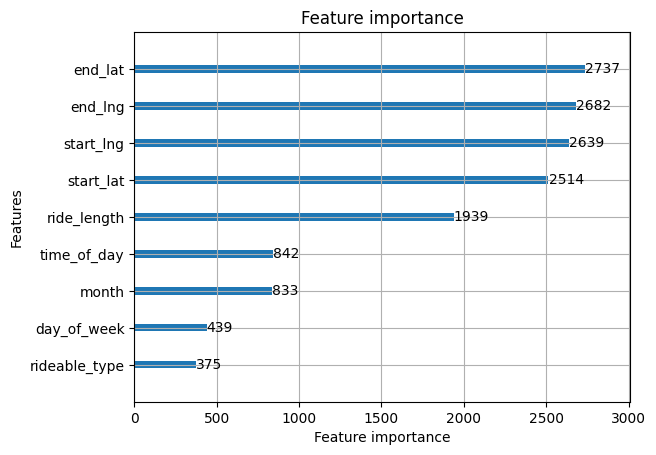

In [82]:
lightgbm.plot_importance(base_lgb)

#### Slight Tuning
Now we will modify the LightGBM model slightly by adding a parameter for *num_leaves*.

In [ ]:
lgb_2 = LGBMClassifier(n_estimators=500, max_depth=10, subsample=0.7, colsample_bytree=0.7, learning_rate=0.3, objective='binary', random_state = 42, num_leaves=1024)
lgb_2.fit(X_train, y_train, eval_set=(X_val, y_val), eval_metric='auc')

In [84]:
lgb_2.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('auc', 0.8019589885537941),
                          ('binary_logloss', 0.5180570075968987)])})

In [85]:
y_pred_lgb_2 = lgb_2.predict(X_val)

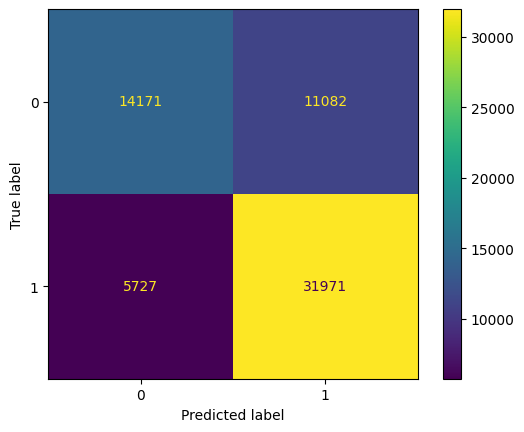

In [86]:
lgb_2_cm = confusion_matrix(y_val, y_pred_lgb_2, labels=lgb_2.classes_)

lgb_2_disp = ConfusionMatrixDisplay(confusion_matrix=lgb_2_cm, display_labels=lgb_2.classes_)

# Plot confusion matrix
lgb_2_disp.plot(values_format='')

plt.show()

In [87]:
print(classification_report(y_val, y_pred_lgb_2))
print("Accuracy:", accuracy_score(y_val, y_pred_lgb_2))
print("Precision:", precision_score(y_val, y_pred_lgb_2))
print("Recall:", recall_score(y_val, y_pred_lgb_2))
print("AUC:", roc_auc_score(y_val, lgb_2.predict_proba(X_val)[:,1]))
print("f-1:", f1_score(y_val, y_pred_lgb_2))

              precision    recall  f1-score   support

           0       0.71      0.56      0.63     25253
           1       0.74      0.85      0.79     37698

    accuracy                           0.73     62951
   macro avg       0.73      0.70      0.71     62951
weighted avg       0.73      0.73      0.73     62951

Accuracy: 0.7329827961430319
Precision: 0.7425963347501916
Recall: 0.8480821263727518
AUC: 0.8019589885537941
f-1: 0.7918415871010885


In [88]:
results.loc[len(results.index)] = ['Slightly tuned LGB', accuracy_score(y_val, y_pred_lgb_2), precision_score(y_val, y_pred_lgb_2), recall_score(y_val, y_pred_lgb_2), roc_auc_score(y_val, lgb_2.predict_proba(X_val)[:,1]), f1_score(y_val, y_pred_lgb_2)]
# pd.to_pickle(results, 'results.pkl')
results

,Model,Accuracy,Precision,Recall,AUC,f-1
0,Logistic Regression,0.651745,0.654014,0.888482,0.673917,0.753428
1,Naive Bayes,0.649172,0.645733,0.917555,0.681950,0.758012
2,Baseline Decision Tree,0.664866,0.723836,0.712027,0.653393,0.717883
3,Tuned Decision Tree,0.701863,0.725314,0.808239,0.754537,0.764535
4,Tuned Random Forest,0.733237,0.743506,0.846597,0.799181,0.791710
5,XGBoost,0.732157,0.743145,0.844687,0.800690,0.790669
6,Baseline LGB,0.718003,0.720915,0.863308,0.777055,0.785713
7,Slightly tuned LGB,0.732983,0.742596,0.848082,0.801959,0.791842


In [89]:
# pd.to_pickle(lgb_2,'tuned_lgb.pkl')
# lgb_2 = pd.read_pickle('tuned_lgb.pkl')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

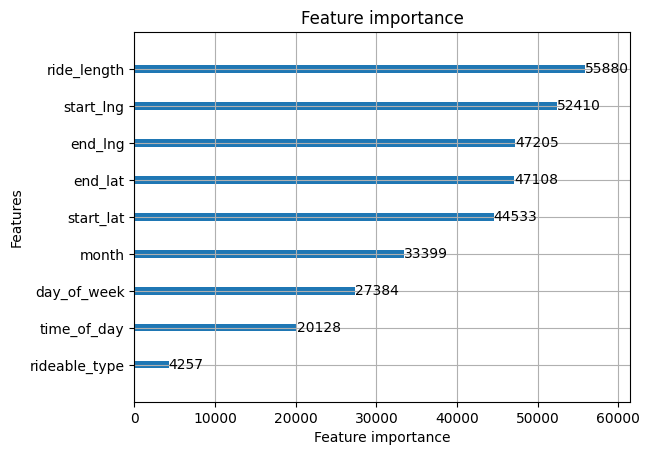

In [90]:
lightgbm.plot_importance(lgb_2)

#### Hyperparameter-tuned LGB

We will test a variety of parameters. First we use GridSearch to find a general direction.
##### GridSearch

In [18]:
lgb = LGBMClassifier(random_state=42, objective='binary', verbosity=-1)
params = {'n_estimators': [250, 500],
           'boosting_type': ['gbdt'],
           'num_leaves': [320, 640],
           'learning_rate': [0.2, 0.3],
           'subsample': [0.7],
           'colsample_bytree': [0.7],
           'min_data_in_leaf': [40, 80]
            }

test_fold = [0 if x in X_val.index else -1 for x in X_train_val.index]

ps = PredefinedSplit(test_fold = test_fold)

gridsearch_lgb_val = GridSearchCV(lgb, param_grid=params, scoring='roc_auc', cv= ps, refit=False, verbose=4)

In [19]:
gridsearch_lgb_val.fit(X_train_val, y_train_val)

Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV 1/1] END boosting_type=gbdt, colsample_bytree=0.7, learning_rate=0.2, min_data_in_leaf=40, n_estimators=250, num_leaves=320, subsample=0.7;, score=0.791 total time= 1.8min
[CV 1/1] END boosting_type=gbdt, colsample_bytree=0.7, learning_rate=0.2, min_data_in_leaf=40, n_estimators=250, num_leaves=640, subsample=0.7;, score=0.797 total time= 2.2min
[CV 1/1] END boosting_type=gbdt, colsample_bytree=0.7, learning_rate=0.2, min_data_in_leaf=40, n_estimators=500, num_leaves=320, subsample=0.7;, score=0.798 total time= 4.0min
[CV 1/1] END boosting_type=gbdt, colsample_bytree=0.7, learning_rate=0.2, min_data_in_leaf=40, n_estimators=500, num_leaves=640, subsample=0.7;, score=0.803 total time= 4.7min
[CV 1/1] END boosting_type=gbdt, colsample_bytree=0.7, learning_rate=0.2, min_data_in_leaf=80, n_estimators=250, num_leaves=320, subsample=0.7;, score=0.790 total time= 3.7min
[CV 1/1] END boosting_type=gbdt, colsample_bytree=0.7, lear

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LGBMClassifier(objective='binary', random_state=42,
                                      verbosity=-1),
             param_grid={'boosting_type': ['gbdt'], 'colsample_bytree': [0.7],
                         'learning_rate': [0.2, 0.3],
                         'min_data_in_leaf': [40, 80],
                         'n_estimators': [250, 500], 'num_leaves': [320, 640],
                         'subsample': [0.7]},
             refit=False, scoring='roc_auc', verbose=4)

In [20]:
gridsearch_lgb_val.best_score_

0.8032743817457773

In [21]:
gridsearch_lgb_val.cv_results_

{'mean_fit_time': array([107.09017491, 131.35026884, 238.97701454, 278.26248884,
        220.6191361 , 249.10988307, 351.48528171, 337.58647871,
        186.33315468, 153.12724805, 300.83163142, 408.91238236,
        222.99473929, 255.97057295, 331.1497407 , 356.33884454]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.86573148, 0.87466025, 1.5921216 , 3.35896921, 1.50609708,
        1.93199778, 2.94468927, 3.57100081, 1.78283072, 1.38343763,
        3.0867095 , 3.15892267, 2.15446997, 2.43397427, 2.60026693,
        2.98060322]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'param_boosting_type': masked_array(data=['gbdt', 'gbdt', 'gbdt', 'gbdt', 'gbdt', 'gbdt', 'gbdt',
                    'gbdt', 'gbdt', 'gbdt', 'gbdt', 'gbdt', 'gbdt', 'gbdt',
                    'gbdt', 'gbdt'],
              mask=[False, False, False, False, False, False, False, False,
          

In [93]:
# pd.to_pickle(gridsearch_lgb_val, 'gs_lgb.pkl')

##### Manual Searches
Next we will manually set different parameters and refine the direction we are moving in.

In [22]:
opt_lgb = LGBMClassifier(random_state=42, objective='binary', n_estimators=500, num_leaves=640, subsample=0.7, colsample_bytree=0.7, min_data_in_leaf=40, learning_rate=0.2)

In [23]:
opt_lgb.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 3694299, number of negative: 2474900
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.320010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1302
[LightGBM] [Info] Number of data points in the train set: 6169199, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598830 -> initscore=0.400591
[LightGBM] [Info] Start training from score 0.400591


LGBMClassifier(colsample_bytree=0.7, learning_rate=0.2, min_data_in_leaf=40,
               n_estimators=500, num_leaves=640, objective='binary',
               random_state=42, subsample=0.7)

In [47]:
roc_auc_score(y_val, opt_lgb.predict_proba(X_val)[:,1])

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


0.8032743817457773

In [31]:
opt_lgb_2 = LGBMClassifier(random_state=42, objective='binary', n_estimators=500, num_leaves=640, min_data_in_leaf=40, subsample=0.8, learning_rate=0.25)
opt_lgb_2.fit(X_train, y_train)
roc_auc_score(y_val, opt_lgb_2.predict_proba(X_val)[:,1])

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 3694299, number of negative: 2474900
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1302
[LightGBM] [Info] Number of data points in the train set: 6169199, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598830 -> initscore=0.400591
[LightGBM] [Info] Start training from score 0.400591
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


0.805043555010865

In [37]:
opt_lgb_3 = LGBMClassifier(random_state=42, objective='binary', n_estimators=500, num_leaves=640, min_data_in_leaf=40, learning_rate=0.225)
opt_lgb_3.fit(X_train, y_train)
roc_auc_score(y_val, opt_lgb_3.predict_proba(X_val)[:,1])

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 3694299, number of negative: 2474900
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1302
[LightGBM] [Info] Number of data points in the train set: 6169199, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598830 -> initscore=0.400591
[LightGBM] [Info] Start training from score 0.400591
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


0.8056469746390413

In [39]:
opt_lgb_4 = LGBMClassifier(random_state=42, objective='binary', n_estimators=500, num_leaves=1280, min_data_in_leaf=40, learning_rate=0.225)
opt_lgb_4.fit(X_train, y_train)
roc_auc_score(y_val, opt_lgb_4.predict_proba(X_val)[:,1])

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Number of positive: 3694299, number of negative: 2474900
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.482831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1302
[LightGBM] [Info] Number of data points in the train set: 6169199, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598830 -> initscore=0.400591
[LightGBM] [Info] Start training from score 0.400591
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


0.8071779903888117

In [40]:
opt_lgb_5 = LGBMClassifier(random_state=42, objective='binary', n_estimators=750, num_leaves=1280, min_data_in_leaf=40, learning_rate=0.225, verbosity=-1)
opt_lgb_5.fit(X_train, y_train)
roc_auc_score(y_val, opt_lgb_5.predict_proba(X_val)[:,1])

0.8079500597987834

In [43]:
opt_lgb_6 = LGBMClassifier(random_state=42, objective='binary', n_estimators=1000, num_leaves=1280, min_data_in_leaf=40, learning_rate=0.225, verbosity=-1)
opt_lgb_6.fit(X_train, y_train)
roc_auc_score(y_val, opt_lgb_6.predict_proba(X_val)[:,1])

0.8084166105215023

In [48]:
y_pred_opt_lgb = opt_lgb_6.predict(X_val)

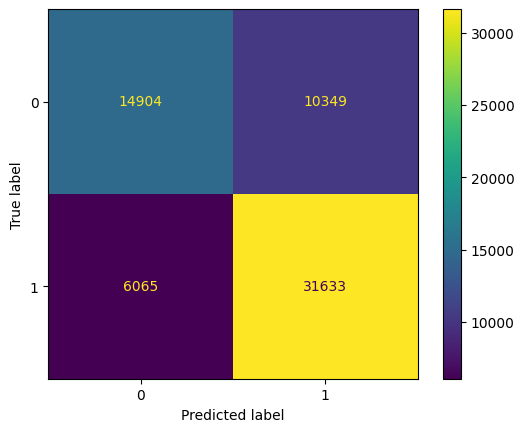

In [49]:
opt_lgb_cm = confusion_matrix(y_val, y_pred_opt_lgb, labels=opt_lgb_6.classes_)

opt_lgb_disp = ConfusionMatrixDisplay(confusion_matrix=opt_lgb_cm, display_labels=opt_lgb_6.classes_)

# Plot confusion matrix
opt_lgb_disp.plot(values_format='')

plt.show()

In [50]:
print(classification_report(y_val, y_pred_opt_lgb))
print("Accuracy:", accuracy_score(y_val, y_pred_opt_lgb))
print("Precision:", precision_score(y_val, y_pred_opt_lgb))
print("Recall:", recall_score(y_val, y_pred_opt_lgb))
print("AUC:", roc_auc_score(y_val, opt_lgb_6.predict_proba(X_val)[:,1]))
print("f-1:", f1_score(y_val, y_pred_opt_lgb))

              precision    recall  f1-score   support

           0       0.71      0.59      0.64     25253
           1       0.75      0.84      0.79     37698

    accuracy                           0.74     62951
   macro avg       0.73      0.71      0.72     62951
weighted avg       0.74      0.74      0.73     62951

Accuracy: 0.7392575177519023
Precision: 0.7534895907769996
Recall: 0.8391161334818823
AUC: 0.8084166105215023
f-1: 0.7940010040160642


In [51]:
results.loc[len(results.index)] = ['Tuned LGB', accuracy_score(y_val, y_pred_opt_lgb), precision_score(y_val, y_pred_opt_lgb), recall_score(y_val, y_pred_opt_lgb), roc_auc_score(y_val, opt_lgb_6.predict_proba(X_val)[:,1]), f1_score(y_val, y_pred_opt_lgb)]
# pd.to_pickle(results, 'results.pkl')
results

,Model,Accuracy,Precision,Recall,AUC,f-1
0,Logistic Regression,0.651745,0.654014,0.888482,0.673917,0.753428
1,Naive Bayes,0.649172,0.645733,0.917555,0.681950,0.758012
2,Baseline Decision Tree,0.664866,0.723836,0.712027,0.653393,0.717883
3,Tuned Decision Tree,0.701863,0.725314,0.808239,0.754537,0.764535
4,Tuned Random Forest,0.733237,0.743506,0.846597,0.799181,0.791710
5,XGBoost,0.732157,0.743145,0.844687,0.800690,0.790669
6,Baseline LGB,0.718003,0.720915,0.863308,0.777055,0.785713
7,Slightly tuned LGB,0.732983,0.742596,0.848082,0.801959,0.791842
8,Tuned LGB,0.739258,0.753490,0.839116,0.808417,0.794001


In [91]:
# pd.to_pickle(opt_lgb_6, 'opt_lgb.pkl')
# opt_lgb_6 = pd.read_pickle('opt_lgb.pkl')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

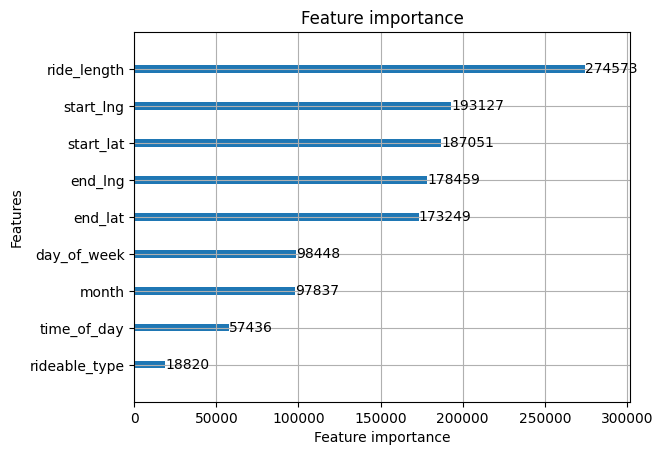

In [92]:
lightgbm.plot_importance(opt_lgb_6)

## Finalization and Testing
Now we will use the testing data and evaluate our models' performances.

In [52]:
results

,Model,Accuracy,Precision,Recall,AUC,f-1
0,Logistic Regression,0.651745,0.654014,0.888482,0.673917,0.753428
1,Naive Bayes,0.649172,0.645733,0.917555,0.681950,0.758012
2,Baseline Decision Tree,0.664866,0.723836,0.712027,0.653393,0.717883
3,Tuned Decision Tree,0.701863,0.725314,0.808239,0.754537,0.764535
4,Tuned Random Forest,0.733237,0.743506,0.846597,0.799181,0.791710
5,XGBoost,0.732157,0.743145,0.844687,0.800690,0.790669
6,Baseline LGB,0.718003,0.720915,0.863308,0.777055,0.785713
7,Slightly tuned LGB,0.732983,0.742596,0.848082,0.801959,0.791842
8,Tuned LGB,0.739258,0.753490,0.839116,0.808417,0.794001


In [56]:
'''
log_clf = pd.read_pickle('log_reg.pkl')
gnb = pd.read_pickle('naive_bayes.pkl')
base_tree = pd.read_pickle('base_tree.pkl')
opt_tree = pd.read_pickle('opt_tree.pkl')
rf = pd.read_pickle('random_forest.pkl')
xgb = pd.read_pickle('xgb.pkl')
base_lgb = pd.read_pickle('base_lgb.pkl')
tuned_lgb = pd.read_pickle('tuned_lgb.pkl')
opt_lgb = pd.read_pickle('opt_lgb.pkl')
'''

In [74]:
models = [log_clf, gnb, base_tree, opt_tree, rf, xgb, base_lgb, tuned_lgb, opt_lgb]

In [75]:
data_dict = {'Model Name': ['Logistic Regression', 'Naive Bayes', 'Baseline Decision Tree', 'Tuned Decision Tree', 'Tuned Random Forest', 'XGBoost', 'Baseline LGB', 'Slightly Tuned LGB', 'Tuned LGB'],
             'AUC': [],
             'Accuracy': [],
             'Precision': [],
             'Recall': [],
             'f-1': []}

for model in models:
    y_pred_model = model.predict(X_test)
    data_dict['AUC'].append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    data_dict['Accuracy'].append(accuracy_score(y_test, y_pred_model))
    data_dict['Precision'].append(precision_score(y_test, y_pred_model))
    data_dict['Recall'].append(recall_score(y_test, y_pred_model))
    data_dict['f-1'].append(f1_score(y_test, y_pred_model))

test_results = pd.DataFrame(data=data_dict)
# pd.to_pickle(test_results, 'test_results.pkl')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [76]:
test_results

,Model Name,AUC,Accuracy,Precision,Recall,f-1
0,Logistic Regression,0.667169,0.647668,0.652484,0.884770,0.751077
1,Naive Bayes,0.674216,0.647652,0.645943,0.915098,0.757317
2,Baseline Decision Tree,0.654935,0.667413,0.725823,0.717398,0.721586
3,Tuned Decision Tree,0.749565,0.697087,0.722247,0.805605,0.761652
4,Tuned Random Forest,0.796328,0.733019,0.744332,0.846298,0.792047
5,XGBoost,0.791651,0.725315,0.738044,0.841433,0.786355
6,Baseline LGB,0.770760,0.714290,0.719083,0.860656,0.783526
7,Slightly Tuned LGB,0.793189,0.726299,0.737749,0.844685,0.787604
8,Tuned LGB,0.802761,0.735322,0.750877,0.837203,0.791694


After evaluation, we see that our Tuned LGB model performed the best on the test data, and achieved an AUC of over 0.8 which is pretty good.

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


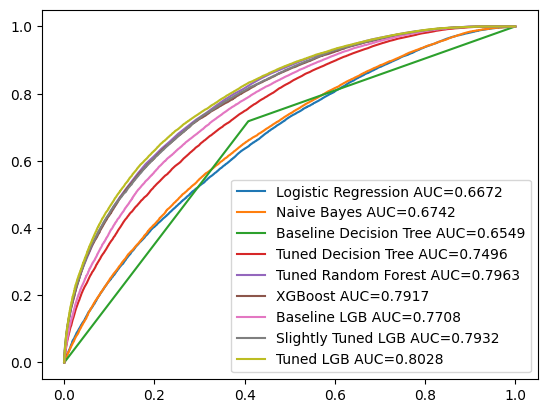

In [80]:
plt.figure(0).clf()

for i in range(len(models)):
    y_pred = models[i].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
    plt.plot(fpr,tpr,label=""+data_dict['Model Name'][i]+" AUC="+str(auc))

#add legend
plt.legend()